In [1]:
import ot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.base import clone
import seaborn as sns
from tqdm import tqdm_notebook

import sklearn
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler

### Generate the problem / prepare selected datasets

In [2]:
nrows = None

In [3]:
numerical_features_index = [0, 2, 4, 10, 11, 12]

data_train = pd.read_csv('../datasets/Adult income dataset/adult.data', nrows=nrows, header=None)
y_train = data_train.loc[:, data_train.columns[-1]]
gender_train = data_train.loc[:, data_train.columns[9]]


data_test = pd.read_csv('../datasets/Adult income dataset/adult.test', skiprows=1, header=None)
y_test = data_test.loc[:, data_train.columns[-1]]
gender_test = data_test.loc[:, data_test.columns[9]]

data_train.drop(data_train.columns.difference(numerical_features_index), axis=1, inplace=True)
data_test.drop(data_test.columns.difference(numerical_features_index), axis=1, inplace=True)
data_train = data_train.astype(np.float64)
data_test = data_test.astype(np.float64)


gender_train = gender_train.apply(lambda x: x.strip())
gender_test = gender_test.apply(lambda x: x.strip())

In [4]:
data_train.shape

(32561, 6)

In [5]:
data_train.drop_duplicates(inplace=True)
y_train = y_train.loc[data_train.index]
gender_train = gender_train.loc[data_train.index]

assert data_train.shape[0] == y_train.shape[0] == gender_train.shape[0]

In [6]:
binarizer = LabelBinarizer()
y_train = binarizer.fit_transform(y_train).ravel()
y_test = binarizer.fit_transform(y_test).ravel()

In [7]:
gender_binarizer = LabelBinarizer()
gender_binary_train = gender_binarizer.fit_transform(gender_train.values).ravel()
gender_binary = gender_binarizer.fit_transform(gender_test.values).ravel()

In [8]:
scaler = StandardScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter

In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
random_seed=777 #tri topora

In [12]:
clf_base = RandomForestClassifier()#random_state=random_seed)

param_grid = {
    'n_estimators': [10, 50, 100, 200, 500, 1000],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 3, 4, 5]
}

In [13]:
# clf_base = GradientBoostingClassifier()

# param_grid = {
#     'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
#     'n_estimators': [100, 200, 500, 1000],
#     'min_samples_split': [2, 3, 4, 5],
#     'max_depth':[None, 2, 3, 4, 5, 6]
# }

In [14]:
# clf_base = LogisticRegression()
# param_grid = {
#     'penalty': ['l1', 'l2'],
#     'C':[0.1, 0.2, 0.5, 1],
# }

In [15]:
clf = GridSearchCV(clf_base, param_grid, n_jobs=-1, verbose=True, refit=True)
clf.fit(data_train, y_train)
clf_predictions = clf.predict(data_test)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  3.0min finished


In [16]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [17]:
print(Counter(y_test))

print(Counter(clf_predictions))

Counter({0: 12435, 1: 3846})
Counter({0: 14259, 1: 2022})


In [18]:
print('Initial accuracy of classification: {}'.format(accuracy_score(y_test, clf_predictions)))

Initial accuracy of classification: 0.8331797801117867


In [19]:
male_entries_index = gender_train[gender_train == 'Male'].index
female_entries_index = gender_train[gender_train == 'Female'].index

male_entries_test_index = gender_test[gender_test == 'Male'].index
female_entries_test_index = gender_test[gender_test == 'Female'].index

In [20]:
n0 = data_train[gender_train == 'Male'].shape[0]
n1 = data_train[gender_train == 'Female'].shape[0]
n0_test = data_test[gender_test == 'Male'].shape[0]
n1_test = data_test[gender_test == 'Female'].shape[0]

emperical_histogram_male = np.ones_like(male_entries_index) / n0
emperical_histogram_female = np.ones_like(female_entries_index) / n1

emperical_histogram_male_test = np.ones_like(male_entries_test_index) / n0_test
emperical_histogram_female_test = np.ones_like(female_entries_test_index) / n1_test

In [21]:
C = ot.dist(data_test[gender_test == 'Male'], data_test[gender_test == 'Female'])

In [22]:
def f(G):
    return 0.5 * np.sum(G**2)


def df(G):
    return G

In [23]:
coupling1 = ot.optim.gcg(emperical_histogram_male_test, emperical_histogram_female_test, C, reg1=1e-3, reg2=1e-1, f=f, df=df, numItermax=100000000, verbose=True)
%time
#coupling1 = ot.stochastic.solve_semi_dual_entropic(emperical_histogram_male_test, emperical_histogram_female_test, C, reg=1, method='SAG', numItermax=100000, log=True)[0]

It.  |Loss        |Delta loss
--------------------------------
    0|1.186516e+01|0.000000e+00


/home/grapefroot/datascience3/lib/python3.6/site-packages/ot/bregman.py:370: RuntimeWarning: divide by zero encountered in true_divide
  v = np.divide(b, KtransposeU)
/home/grapefroot/datascience3/lib/python3.6/site-packages/ot/bregman.py:370: RuntimeWarning: overflow encountered in true_divide
  v = np.divide(b, KtransposeU)


    1|1.186052e-01|-9.903910e+01
    2|1.185269e-03|-9.906612e+01
    3|1.152485e-05|-1.018446e+02
    4|-2.080268e-07|-5.640080e+01
    5|-3.253101e-07|-3.605275e-01
    6|-3.264824e-07|-3.590933e-03
    7|-3.264942e-07|-3.589408e-05
    8|-3.264943e-07|-3.588011e-07
    9|-3.264943e-07|-3.586604e-09
   10|-3.264943e-07|-3.587646e-11
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


In [24]:
%%time
coupling = ot.emd(emperical_histogram_male_test, emperical_histogram_female_test, C, numItermax=1000000000)

CPU times: user 31.6 s, sys: 695 ms, total: 32.3 s
Wall time: 32.2 s


In [25]:
num = 100

In [26]:
y_first = y_test[gender_test == 'Male']
y_second = y_test[gender_test == 'Female']
print('class 0 size {}'.format(y_first.shape))
print('class 1 size {}'.format(y_second.shape))

class 0 size (10860,)
class 1 size (5421,)


In [27]:
from mapper import full_repair, partial_repair, random_repair
from utils import balanced_error_rate, disparate_impact, disparate_impact_1, likelihood_ratio

In [28]:
def subsample_maps(num_samples, num_couplings, data_first, data_second, y_first, y_second, coupling_function):
    assert num_samples < min(len(data_first, data_second))
    index_1 = np.random.choice(np.arange(0, len(data_first)), size=num_samples, replace=False)
    index_2 = np.random.choice(np.arange(0, len(data_second)), size=num_samples, replace=False)
    couplings = []
    for coupling_index in range(num_couplings):
        coupling = coupling_function(data_first[index_1], data_second[index_2], y_first[index_1], y_second[index_2])
        couplings.append(coupling)
    return couplings

In [29]:
acs = []
dims = []

for repair_value in tqdm_notebook(np.linspace(0, 1, num=num)):
    X_new, y_new = partial_repair(repair_value, data_test[gender_test == 'Male'], data_test[gender_test == 'Female'], coupling, y_first, y_second)
    #clf1 = clone(clf_base)
    #clf1.fit(X_new, y_new)
    accuracy_sc = accuracy_score(y_new, clf.predict(X_new))
    disparate_im = disparate_impact_1(clf.predict(X_new), gender_binary)
    acs.append(accuracy_sc)
    dims.append(disparate_im)

In [30]:
acs_1 = []
dims_1 = []

for repair_value in tqdm_notebook(np.linspace(0, 1, num=num)):
    X_new, y_new = partial_repair(repair_value, data_test[gender_test == 'Male'], data_test[gender_test == 'Female'], coupling1, y_first, y_second)
#     clf1 = clone(clf_base)
#     clf1.fit(X_new, y_new)
    accuracy_sc = accuracy_score(y_new, clf.predict(X_new))
    disparate_im = disparate_impact_1(clf.predict(X_new), gender_binary)
    acs_1.append(accuracy_sc)
    dims_1.append(disparate_im)

In [31]:
acs_2 = []
dims_2 = []

for repair_value in tqdm_notebook(np.linspace(0, 1, num=num)):
    X_new, y_new = random_repair(repair_value, 0.5, data_test[gender_test == 'Male'], data_test[gender_test == 'Female'], coupling, y_first, y_second)
#     clf1 = clone(clf_base)
#     clf1.fit(X_new, y_new)
    accuracy_sc = accuracy_score(y_new, clf.predict(X_new))
    disparate_im = disparate_impact_1(clf.predict(X_new), gender_binary)
    acs_2.append(accuracy_sc)
    dims_2.append(disparate_im)

In [32]:
acs_3 = []
dims_3 = []

for repair_value in tqdm_notebook(np.linspace(0, 1, num=num)):
    X_new, y_new = random_repair(repair_value, 0.5, data_test[gender_test == 'Male'], data_test[gender_test == 'Female'], coupling1, y_first, y_second)
#     clf1 = clone(clf_base)
#     clf1.fit(X_new, y_new)
    accuracy_sc = accuracy_score(y_new, clf.predict(X_new))
    disparate_im = disparate_impact_1(clf.predict(X_new), gender_binary)
    acs_3.append(accuracy_sc)
    dims_3.append(disparate_im)

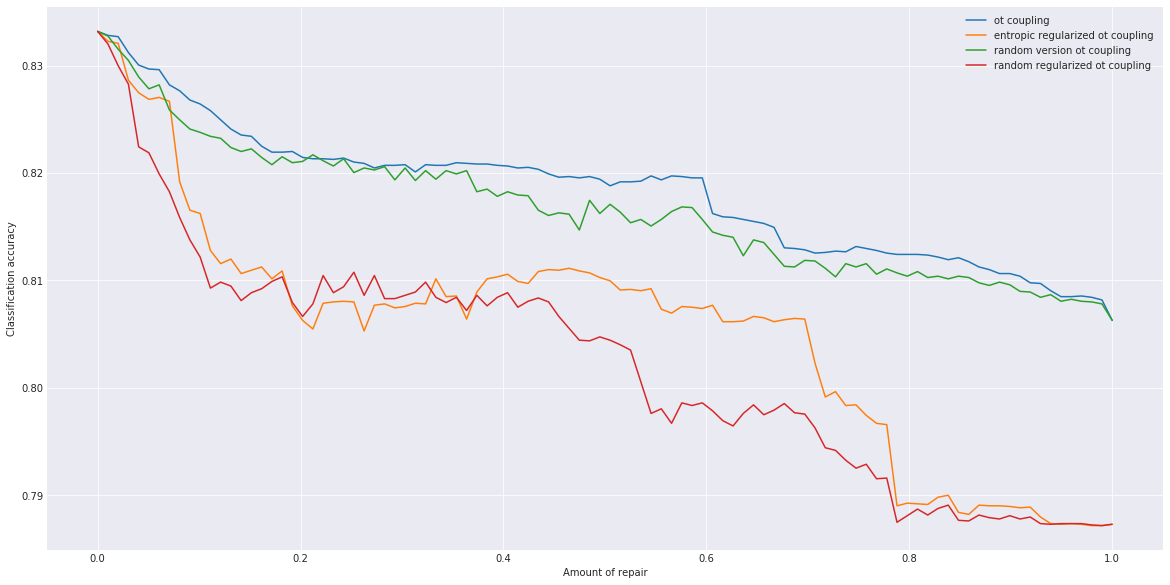

In [33]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(20, 10))
    plt.plot(np.linspace(0, 1, num), acs, label='ot coupling')
    plt.plot(np.linspace(0, 1, num), acs_1, label='entropic regularized ot coupling')
    plt.plot(np.linspace(0, 1, num), acs_2, label='random version ot coupling')
    plt.plot(np.linspace(0, 1, num), acs_3, label='random regularized ot coupling')
    plt.xlabel('Amount of repair')
    plt.ylabel('Classification accuracy')
    plt.savefig('./accuracy_comparison.png', bbox_inches='tight')
    plt.legend()

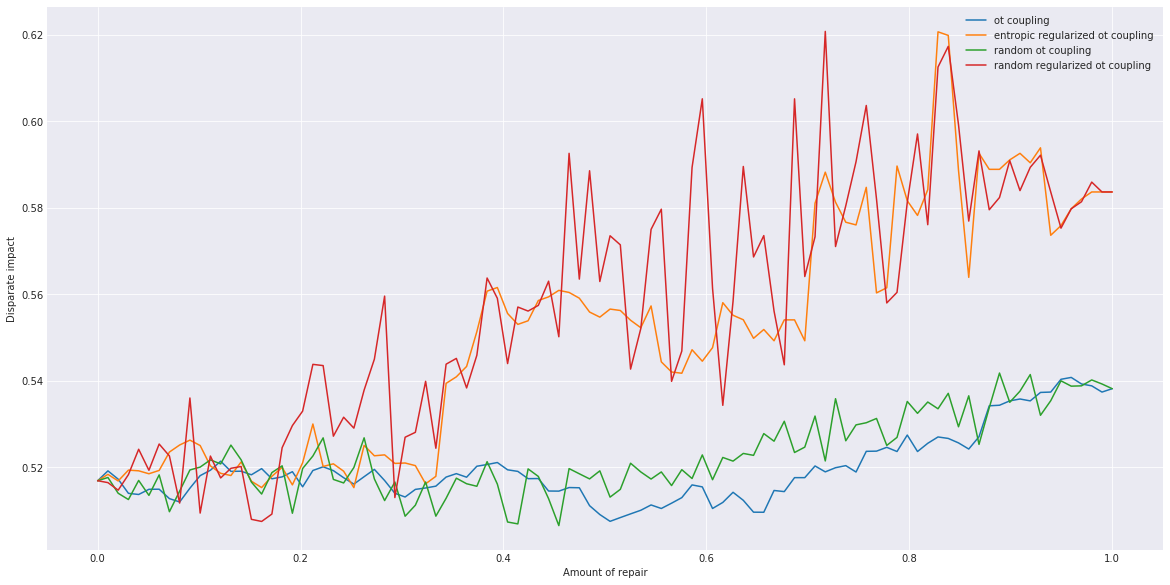

In [34]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(20, 10))
    plt.plot(np.linspace(0, 1, num), dims, label='ot coupling')
    plt.plot(np.linspace(0, 1, num), dims_1, label='entropic regularized ot coupling')
    plt.plot(np.linspace(0, 1, num), dims_2, label='random ot coupling')
    plt.plot(np.linspace(0, 1, num), dims_3, label='random regularized ot coupling')
    plt.legend()
    plt.xlabel('Amount of repair')
    plt.ylabel('Disparate impact')
    plt.savefig('./disparate_impact_comparison.png', bbox_inches='tight')
    plt.show()

### Show that different solutions for the same transporation problem can have different target metric value

### Explore how the regularized barycenters are defined, try to apply them to the problem

### Use the regularized transport maps instead of usual ones